In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Users\clima\Desktop\Aptamers\src')

from sklearn.manifold import TSNE
from APTamers import  Aptamer_Fold
import pandas as pd
import forgi.visual.mplotlib as fvm
from sklearn.feature_selection import VarianceThreshold
from forgi.graph.bulge_graph import BulgeGraph
import matplotlib.pyplot as plt
from dna import DNA_ENERGIES

In [2]:
df = pd.read_csv(r'C:\Users\clima\Desktop\Aptamers\data\preprocessed _files\UNAfold_merged_all.csv')
df = df.drop_duplicates(subset='Sequence')
print('Numeber of unique sequences after preprocessing:',len(df))
percentile_95 = np.percentile(df['Sequence'].apply(len), 95) 
percentile_5 = np.percentile(df['Sequence'].apply(len), 5)
# Filter DataFrame to remove rows with list lengths outside the 95th percentile
df = df[df['Sequence'].apply(len).between(np.floor(percentile_5)+1, np.ceil(percentile_95))]
df.reset_index()
BpEnergy = DNA_ENERGIES.TRI_TETRA_LOOPS
subsequence = list(BpEnergy.keys())

Numeber of unique sequences after preprocessing: 4933


In [3]:
def find_consecutive_dots(string):
    dot_locations = []  # List to store locations of consecutive dots
    consecutive_dots = []  # List to store consecutive dot sequences
    for i, char in enumerate(string):
        if char == '.':
            dot_locations.append(i)
        else:
            if len(dot_locations) > 0:
                consecutive_dots.append(dot_locations)
            dot_locations = []
    return consecutive_dots

def bag_of_sequences(subsequence, sequence, consecutive_dots):
    desc = np.zeros(len(subsequence), dtype = int)
    for count, sub in enumerate(subsequence):
        for m in consecutive_dots:
                lis =  ''.join([sequence[n] for n in m])
                if sub in lis:
                    desc[count]+=1
    return desc
                    
def descriptors(sequence, structure):
    consecutive_dots = find_consecutive_dots(structure)
    return bag_of_sequences(subsequence, sequence, consecutive_dots)
    
    
def compute_descriptor_motzkin(input_string):
    descriptor = []
    sum = 0
    for  char in input_string:
        if char == '(':
            sum +=1
            descriptor.append(sum)
        elif char == ')':
            sum -=1 
            descriptor.append(sum)
        elif char == '.':
            descriptor.append(sum)      
    return descriptor


def dna_descriptor(sequence, n_max):
    # Create an array of zeros with the same length as the sequence
    complete_descriptor = []
    for l in ['A', 'C', 'T', 'G']:
        descriptor = np.zeros(len(sequence), dtype=int)
        descriptor[ np.where(np.array(list(sequence)) == l)[0]] = 1
        
        complete_descriptor +=descriptor.tolist()
        complete_descriptor+=np.zeros(n_max -len(sequence), dtype=int).tolist()
    return np.asarray(complete_descriptor)               

# Descriptors Bag of Sequences

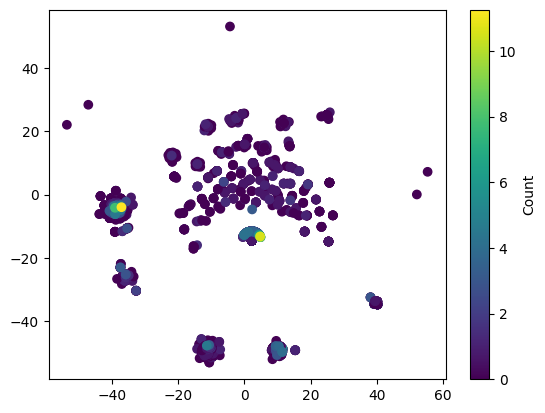

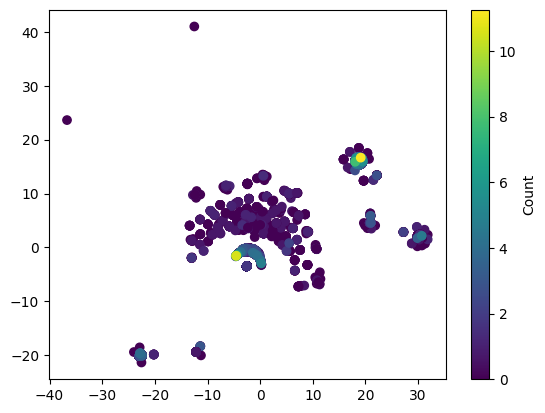

In [4]:

X_raw= np.zeros((len(df), len(subsequence)), dtype=int)
for count, (seq, str) in enumerate(zip(df['Sequence'], df['Structure_UNA'])):
    X_raw[count, :] =  descriptors(seq, str)
    

 
selector = VarianceThreshold(0)
X = selector.fit_transform(X_raw) 


X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=50).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')
plt.colorbar(label='Count')
plt.show()

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=150).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors[::-1], cmap='viridis')

plt.colorbar(label='Count')
plt.show()

# Descritpors MotzkinPath

(4450, 88)


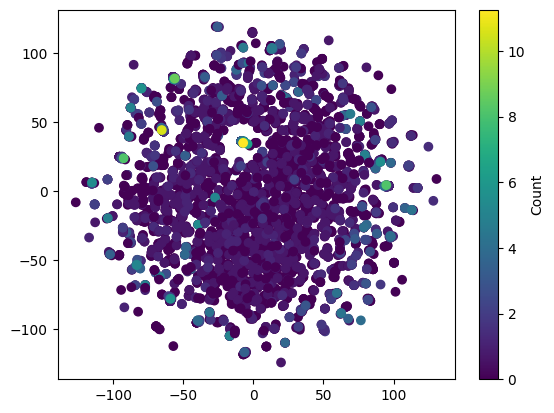

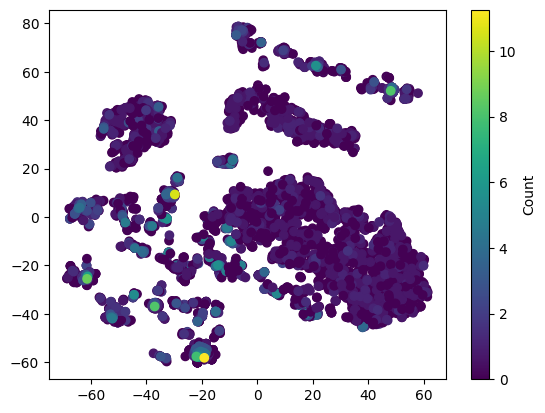

In [5]:
df['Descriptor'] = df['Structure_UNA'].apply(lambda x: compute_descriptor_motzkin(x) )
# Determine the maximum length of the lists
max_length = df['Descriptor'].apply(len).max()

# Convert the lists column into a numpy array with padding
X_raw = np.zeros((len(df), max_length), dtype=int)
for i, row in enumerate(df['Descriptor']):
    X_raw[i,:len(row)] = row
 
selector = VarianceThreshold(0)
X = selector.fit_transform(X_raw) 

print(X.shape)

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=3).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')
plt.colorbar(label='Count')
plt.show()


X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42, perplexity=30).fit_transform(X)
X_embedded = X_embedded
colors =np.log(df['Count'])
plt.scatter(X_embedded[::-1,0], X_embedded[::-1,1],c=colors [::-1], cmap='viridis')
plt.colorbar(label='Count')
plt.show()


In [9]:
def find_hairpin_loops(dot_bracket):
    hairpin_loops = []
    stack = []

    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                start = stack.pop()
                loop_start = start + 1
                loop_end = i - 1
                loop= dot_bracket[loop_start:loop_end + 1]
                # Check if the region between start and i is a hairpin loop
                if loop.count('.') > 0 and '(' not in loop and ')' not in loop:
                    hairpin_loops.append((loop_start, loop_end + 1))

    return hairpin_loops


def find_bulges(dot_bracket, max_bulge_length=3):
    bulges = []
    stack = []

    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                start = stack.pop()
                loop_start = start + 1
                loop_end = i - 1

                # Check if the region between start and i is a bulge
                if dot_bracket[loop_start:loop_end + 1].count('.') > 0:
                    bulge_start = loop_start
                    bulge_end = loop_end

                    # Adjust the bulge boundaries based on adjacent base pairs
                    while bulge_start > 0 and dot_bracket[bulge_start - 1] == '.':
                        bulge_start -= 1
                    while bulge_end < len(dot_bracket) - 1 and dot_bracket[bulge_end + 1] == '.':
                        bulge_end += 1

                    # Check if the bulge meets the maximum length constraint
                    if bulge_end - bulge_start + 1 <= max_bulge_length:
                        bulges.append((bulge_start, bulge_end - bulge_start + 1))

    return bulges

# Example usage:
dot_bracket_notation = df['Structure_UNA'][0]
bulges = find_hairpin_loops(dot_bracket_notation)
print("Bulges found:", bulges)


dot_bracket_notation = df['Structure_graph_match'][0]
bulges = find_hairpin_loops(dot_bracket_notation)
print("Bulges found:", bulges)



Bulges found: [(15, 18), (36, 39)]
Bulges found: [(19, 26)]


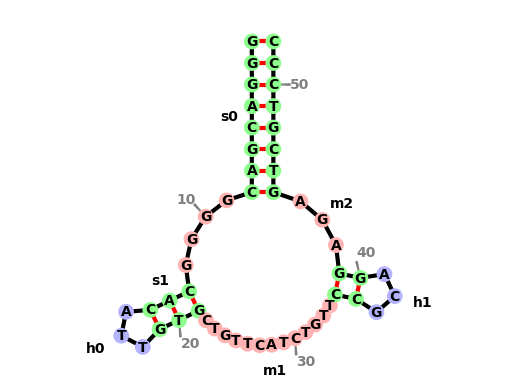

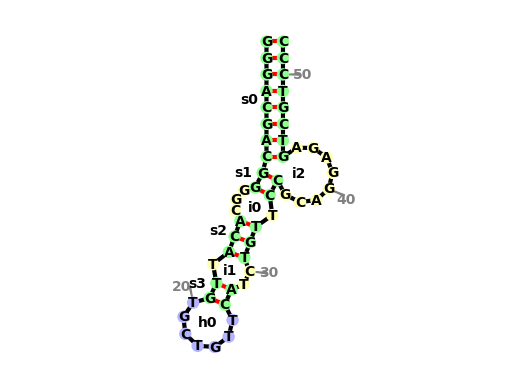

In [8]:
seqs = Aptamer_Fold().fit_fold(sequence= df['Sequence'][0],  n_tmpl=4, l_fix=8 ,  return_min = False, filters = False)
bg = BulgeGraph.from_dotbracket( df['Structure_UNA'][0] ,  df['Sequence'][0] )

fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
plt.show()

bg = BulgeGraph.from_dotbracket( df['Structure_graph_match'][0] ,  df['Sequence'][0] )

fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,backbone_kwargs={"linewidth":3})
plt.show()